<a href="https://colab.research.google.com/github/slegro97/surviving-titanic/blob/main/SurvivingTitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functions

In [ ]:
def remove_outliers_using_iqr(df, iqr_multiplier=1.5):
    for column in df.columns:
        # Skip binary variables
        if len(df[column].unique()) > 2:
            # Calculate Q1 (25th percentile) and Q3 (75th percentile)
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)

            # Calculate the Interquartile Range (IQR)
            IQR = Q3 - Q1

            # Define lower and upper bounds for outliers
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR

            # Filter the values based on the IQR range for each column
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


In [ ]:
def remove_outliers_using_std(df, threshold=3):
    for column in df.columns:
        # Skip binary variables
        if len(df[column].unique()) > 2:
            mean = df[column].mean()
            std = df[column].std()
            # Define bounds for the acceptable range
            lower_bound = mean - threshold * std
            upper_bound = mean + threshold * std
            # Filter the values based on the standard deviation range for each column
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [ ]:
def evaluate_classification_model(y_true, y_pred):
    """
    Evaluates a classification model by computing the accuracy, F1-score, sensitivity, and specificity.

    Parameters:
    y_true : array-like
        True labels of the samples.
    y_pred : array-like
        Predicted labels of the samples.

    Example usage:
        y_true = [1, 0, 1, 1, 0]
        y_pred = [1, 0, 0, 1, 1]
        evaluate_classification_model(y_true, y_pred)
    """

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:")
    print("  - Measures the proportion of correctly classified instances out of the total instances.")
    print(f"  - Result: {accuracy:.2f}\n")

    # F1-Score
    f1 = f1_score(y_true, y_pred)
    print("F1-Score:")
    print("  - Harmonic mean of precision and recall, balances both false positives and false negatives.")
    print(f"  - Result: {f1:.2f}\n")

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity (Recall):")
    print("  - Measures the proportion of actual positives that are correctly identified as such.")
    print(f"  - Result: {sensitivity:.2f}\n")

    # Specificity
    specificity = tn / (tn + fp)
    print("Specificity:")
    print("  - Measures the proportion of actual negatives that are correctly identified as such.")
    print(f"  - Result: {specificity:.2f}\n")


In [ ]:
def interpret_logistic_regression(model):
    """
    Automatically interprets a logistic regression model from statsmodels, differentiating between binary and continuous variables.

    Parameters:
    model: statsmodels logistic regression results (fitted model)

    Returns:
    None - prints interpretation of coefficients (excluding the intercept)
    """

    # Get the model coefficients, p-values, and exogenous data (independent variables)
    params = model.params
    pvalues = model.pvalues
    exog_data = model.model.exog
    exog_names = model.model.exog_names

    # Get the design matrix as a DataFrame for easier processing
    exog_df = pd.DataFrame(exog_data, columns=exog_names)

    for var in exog_names:
        # Skip the intercept (usually named 'const')
        if var == 'const':
            continue

        coef = params[var]
        pval = pvalues[var]

        # Determine if the variable is binary (has only two unique values)
        unique_values = exog_df[var].unique()
        if len(unique_values) == 2 and set(unique_values).issubset({0, 1}):
            var_type = 'binary'
        else:
            var_type = 'continuous'

        # Check statistical significance
        significance = "statistically significant" if pval < 0.05 else "not statistically significant"

        # Calculate the percentage increase/decrease
        percentage_change = (np.exp(coef) - 1) * 100

        # Generate interpretation based on variable type
        if var_type == 'binary':
            if coef > 0:
                interpretation = (f"For the binary variable '{var}':\n"
                                  f"- Being in the group coded as 1 increases the odds of the outcome by {percentage_change:.2f}%\n"
                                  f"- It is {significance}.")
            else:
                interpretation = (f"For the binary variable '{var}':\n"
                                  f"- Being in the group coded as 1 decreases the odds of the outcome by {abs(percentage_change):.2f}%\n"
                                  f"- It is {significance}.")

        elif var_type == 'continuous':
            if coef > 0:
                interpretation = (f"For the continuous variable '{var}':\n"
                                  f"- A one-unit increase leads to a {percentage_change:.2f}% increase in the odds of the outcome\n"
                                  f"- It is {significance}.")
            else:
                interpretation = (f"For the continuous variable '{var}':\n"
                                  f"- A one-unit increase leads to a {abs(percentage_change):.2f}% decrease in the odds of the outcome\n"
                                  f"- It is {significance}.")

        # Print interpretation with a separator line
        print(interpretation)
        print("-" * 50)


# Libraries and Data

In [ ]:
%cd /content/drive/MyDrive/PythonProjects/Statistics with Python/Regression Analysis/Capstone Project_ Titanic Survivor Prediction

/content/drive/MyDrive/PythonProjects/Statistics with Python/Regression Analysis/Capstone Project_ Titanic Survivor Prediction


In [ ]:
# Libraries
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [ ]:
# Data
data = pd.read_csv('titanic.csv')
data.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


# Exploratory Data Analysis

In [ ]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [ ]:
# Data summary statistics
data.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


# Data Cleaning and Preparation

In [ ]:
# Drop unnecessary column 'Name'
df = data.drop(columns='Name')

# Transforming the "Sex" column into a binary variable (0 for male, 1 for female)
df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})

# Transforming the "Pclass" column into dummy variables and converting to int type
pclass_dummies = pd.get_dummies(df['Pclass'], prefix='Pclass', drop_first=True).astype(int)

# Concatenate the dummy variables to the original DataFrame
df = pd.concat([df, pclass_dummies], axis=1)

# Drop original Pclass column
df = df.drop('Pclass', axis=1)

# Display the updated DataFrame to check the changes
df.head()

,Survived,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Pclass_2,Pclass_3
0,0,0,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,0,0
2,1,1,26.0,0,0,7.9250,0,1
3,1,1,35.0,1,0,53.1000,0,0
4,0,0,35.0,0,0,8.0500,0,1


In [ ]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Sex                      887 non-null    int64  
 2   Age                      887 non-null    float64
 3   Siblings/Spouses Aboard  887 non-null    int64  
 4   Parents/Children Aboard  887 non-null    int64  
 5   Fare                     887 non-null    float64
 6   Pclass_2                 887 non-null    int64  
 7   Pclass_3                 887 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.6 KB


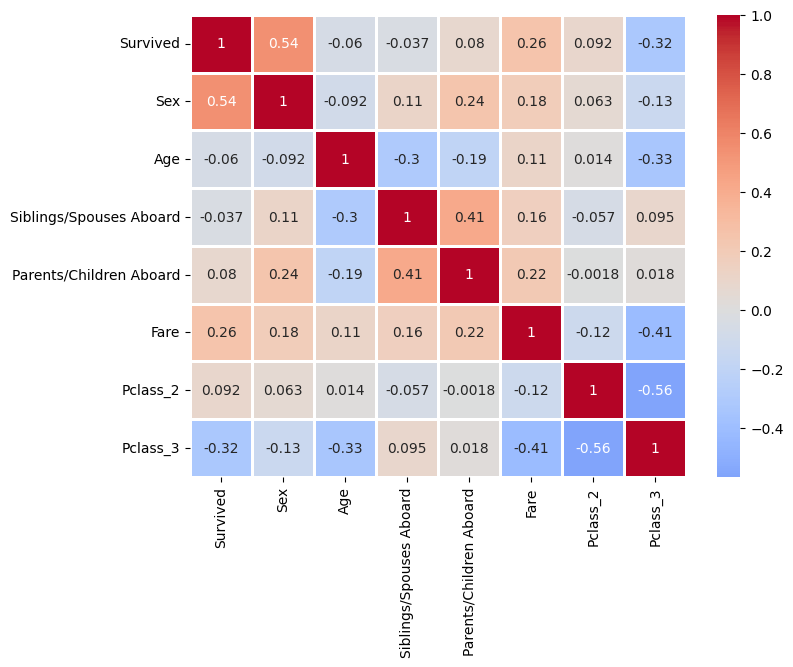

In [ ]:
# Create the correlation matrix object
correlation_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot = True,
            cmap = 'coolwarm',
            linewidths = 1,
            linecolor = 'white',
            center = 0)
plt.show()

In [ ]:
# Remove outliers using 3 std rule
df = remove_outliers_using_std(df, threshold = 3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 821 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 821 non-null    int64  
 1   Sex                      821 non-null    int64  
 2   Age                      821 non-null    float64
 3   Siblings/Spouses Aboard  821 non-null    int64  
 4   Parents/Children Aboard  821 non-null    int64  
 5   Fare                     821 non-null    float64
 6   Pclass_2                 821 non-null    int64  
 7   Pclass_3                 821 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 57.7 KB


# Logistic Regression Preparation

In [ ]:
# Isolate X and y and add constant to X
y = df.Survived
X = df.drop(columns='Survived')
X = sm.add_constant(X)

In [ ]:
# Training and Test split
X_train, X_test, y_train, y_test, = train_test_split(X, y,
                                                     test_size = 0.2)

X_train.head()

,const,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Pclass_2,Pclass_3
652,1.0,0,24.0,2,0,73.5000,1,0
211,1.0,0,22.0,0,0,7.2500,0,1
874,1.0,0,23.0,0,0,7.8958,0,1
773,1.0,1,5.0,0,0,12.4750,0,1
443,1.0,1,13.0,0,1,19.5000,1,0


# Perform Logistic Regression

In [ ]:
# Generate the model
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.435817
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  656
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                            7
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                  0.3380
Time:                        19:50:16   Log-Likelihood:                -285.90
converged:                       True   LL-Null:                       -431.89
Covariance Type:            nonrobust   LLR p-value:                 3.107e-59
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.9791      0.541      1.809      0.071      -0.082   

In [ ]:
# Apply the interpreter function
interpret_logistic_regression(model)

For the binary variable 'Sex':
- Being in the group coded as 1 increases the odds of the outcome by 1611.11%
- It is statistically significant.
--------------------------------------------------
For the continuous variable 'Age':
- A one-unit increase leads to a 4.02% decrease in the odds of the outcome
- It is statistically significant.
--------------------------------------------------
For the continuous variable 'Siblings/Spouses Aboard':
- A one-unit increase leads to a 40.79% decrease in the odds of the outcome
- It is statistically significant.
--------------------------------------------------
For the continuous variable 'Parents/Children Aboard':
- A one-unit increase leads to a 11.57% increase in the odds of the outcome
- It is not statistically significant.
--------------------------------------------------
For the continuous variable 'Fare':
- A one-unit increase leads to a 0.61% increase in the odds of the outcome
- It is not statistically significant.
---------------------

# Accuracy Assessment

In [ ]:
# Predictions
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

In [ ]:
# Check if y is balanced or imbalanced --> threshold of 35%
y_test.mean()

0.4727272727272727

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[73 14]
 [26 52]]


In [ ]:
# Perform and evaluate classification report
evaluate_classification_model(y_test, predictions)

Accuracy:
  - Measures the proportion of correctly classified instances out of the total instances.
  - Result: 0.76

F1-Score:
  - Harmonic mean of precision and recall, balances both false positives and false negatives.
  - Result: 0.72

Sensitivity (Recall):
  - Measures the proportion of actual positives that are correctly identified as such.
  - Result: 0.67

Specificity:
  - Measures the proportion of actual negatives that are correctly identified as such.
  - Result: 0.84

